In [1]:
# Creates: graphene_eps.png
import matplotlib.pyplot as plt
import numpy as np
from ase import Atoms
from ase.units import Hartree, Bohr
from ase.utils import seterr
from itertools import product
from tqdm import tqdm

from gpaw import GPAW, FermiDirac
from gpaw.wavefunctions.pw import PW
from gpaw.response.df import DielectricFunction
from gpaw.mpi import world
from gpaw.bztools import find_high_symmetry_monkhorst_pack
from gpaw.wavefunctions.pw import PWDescriptor
from gpaw.kpt_descriptor import KPointDescriptor

a = 2.5
c = 15
PW_cut=800
nbands=8
atoms = Atoms(symbols='C2', positions=[(0.5 * a, -np.sqrt(3) / 6 * a, 0.5*c),
                                    (0.5 * a, np.sqrt(3) / 6 * a, 0.5*c)],
           cell=[(0.5 * a, -0.5 * 3**0.5 * a, 0),
                 (0.5 * a, 0.5 * 3**0.5 * a, 0),
                 (0.0, 0.0, c )], pbc=True)

calc = GPAW(mode=PW(PW_cut),xc='PBE',
            kpts={'size': (12, 12, 1), 'gamma': True},
            setups='sg15',
            nbands=2*nbands,
            occupations=FermiDirac(0.001),
            convergence={'bands': nbands})

atoms.set_calculator(calc)
atoms.get_potential_energy()
calc.write('gs.gpw')


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.4.0
 |___|_|             

User:   yzhumagulov@cpqm1
Date:   Fri Feb 22 15:11:46 2019
Arch:   x86_64
Pid:    38571
Python: 3.7.2
gpaw:   /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/ase (version 3.16.2)
numpy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/numpy (version 1.15.1)
scipy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/scipy (version 1.1.0)
units:  Angstrom and eV
cores:  1

Input parameters:
  convergence: {bands: 8}
  kpts: {gamma: True,
         size: (12, 12, 1)}
  mode: {ecut: 800.0,
         name: pw}
  nbands: 16
  occupations: {name: fermi-dirac,
                width: 0.001}
  setups: sg15
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, init

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.ifft(a, n, axis)


Creating initial wave functions:
  8 bands from LCAO basis set
  8 bands from random numbers

                 
                 
                 
                 
       CC        
                 
                 
                 
                 

Positions:
   0 C      1.250000   -0.721688    7.500000    ( 0.0000,  0.0000,  0.0000)
   1 C      1.250000    0.721688    7.500000    ( 0.0000,  0.0000,  0.0000)

Unit cell:
           periodic     x           y           z      points  spacing
  1. axis:    yes    1.250000   -2.165064    0.000000    14     0.1546
  2. axis:    yes    1.250000    2.165064    0.000000    14     0.1546
  3. axis:    yes    0.000000    0.000000   15.000000    98     0.1531

  Lengths:   2.500000   2.500000  15.000000
  Angles:   90.000000  90.000000 120.000000

Effective grid spacing dv^(1/3) = 0.1617

                     log10-error:    total        iterations:
           time      wfs    density  energy       fermi  poisson
iter:   1  15:11:49  +2.2

In [20]:
import numba

@numba.jit(nopython=True,parallel=True,fastmath=True)
def operator_matrix_periodic(matrix,operator,wf_conj,wf):
    """perform integration of periodic part of Kohn Sham wavefunction"""
    NK=matrix.shape[0]
    nbands=matrix.shape[1]
    for k in numba.prange(NK):
        for n1 in range(nbands):
            for n2 in range(nbands):
                matrix[k,n1,n2]=np.sum(operator*wf_conj[n1,k]*wf[n2,k])
    return matrix

@numba.jit(nopython=True,parallel=True,fastmath=True)
def Fock_matrix(matrix,V,M_conj,M,occupation,ibz_map):
    """perform integration of periodic part of Kohn Sham wavefunction"""
    nbands=matrix.shape[1]
    NK=V.shape[0]
    NKF=V.shape[1]
    for k in numba.prange(NK):
        for n1 in range(nbands):
            for n2 in range(nbands):
                for q in range(NKF):
                    for m in range(nbands):
                        matrix[k,n1,n2]+=np.sum(occupation[ibz_map[q],m]*V[k,q]*M_conj[m,n1,ibz_map[q],k]*M[m,n2,ibz_map[q],k])
    matrix/=NKF
    return matrix

In [30]:
class TDHF(object):
    """
    Time-dependent Hartree-Fock:
    
        calc: GPAW calculator (symmetry='off' is preferable)
        nbands (int): number of unoccupied bands in calculation
        
    """
    
    def __init__(self,calc,nbands=None):
        self.calc=calc # GPAW calculator object
        self.K=calc.get_ibz_k_points() # reduced Brillioun zone
        self.NK=self.K.shape[0] 
        
        self.wk=calc.get_k_point_weights() # weight of reduced Brillioun zone
        
        self.EK=[calc.get_eigenvalues(k) for k in range(self.NK)] # bands energy
        self.EK=np.array(self.EK)/Hartree
        
        self.nvalence=int(calc.occupations.nvalence/2) #number of valence bands
        if nbands is None:
            self.nbands=2*self.nvalence
        else:
            self.nbands=nbands+self.nvalence
        
        self.shape=tuple(calc.get_number_of_grid_points()) # shape of real space grid
        self.density=calc.get_pseudo_density()*Bohr**3 # density at zero time
        
        
        # array of u_nk (periodic part of Kohn-Sham orbitals,only reduced Brillion zone)
        self.unk=np.zeros((self.nbands,self.NK,)+self.shape,dtype=np.complex) 
        for k in range(self.NK):
            kpt = calc.wfs.kpt_u[k]
            for n in range(self.nbands):
                psit_G = kpt.psit_nG[n]
                psit_R = calc.wfs.pd.ifft(psit_G, kpt.q)
                self.unk[n,k]=psit_R 
                
        self.icell=2.0 * np.pi * calc.wfs.gd.icell_cv # inverse cell 
        self.cell = calc.wfs.gd.cell_cv # cell
        self.z=calc.wfs.gd.get_grid_point_coordinates()[2]-self.cell[2,2]/2.
        self.volume = np.abs(np.linalg.det(calc.wfs.gd.cell_cv)) # volume of cell
        self.norm=calc.wfs.gd.dv # 
        self.Fermi=self.calc.get_fermi_level()/Hartree #Fermi level
        
        #desriptors at q=gamma for Hartree
        self.kdH=KPointDescriptor([[0,0,0]]) 
        self.pdH=PWDescriptor(ecut=calc.wfs.pd.ecut,gd=calc.wfs.gd,kd=self.kdH,dtype=complex)
        
        #desriptors at q=gamma for Fock
        self.kdF=KPointDescriptor([[0,0,0]]) 
        self.pdF=PWDescriptor(ecut=calc.wfs.pd.ecut/4.,gd=calc.wfs.gd,kd=self.kdF,dtype=complex)
        
        #Fermi-Dirac temperature
        self.temperature=calc.occupations.width
        
        #calculate pair-density matrices
        self.M=np.zeros((self.nbands,self.nbands,self.NK,self.NK,self.pdF.get_reciprocal_vectors().shape[0]),dtype=np.complex)
        indexes=[(n,k) for n,k in product(range(self.nbands),range(self.NK))]
        for i1 in range(len(indexes)):
            n1,k1=indexes[i1]
            for i2 in range(i1,len(indexes)):
                n2,k2=indexes[i1]
                self.M[n1,n2,k1,k2]=self.pdF.fft(self.unk[n1,k1].conj()*self.unk[n2,k2])
                self.M[n2,n1,k2,k1]=self.M[n1,n2,k1,k2].conj()
        self.M*=calc.wfs.gd.dv
        
    def plane_wave(self,k):
        """ 
        return plane wave defined on real space grid:
        if k is integer wave vector defined as k-th k-point of reduced Brillioun zone
        if k is array wave vector defined as np.dot(k,self.icell)
        """ 
        if type(k)==int:
            return self.calc.wfs.gd.plane_wave(self.K[k])
        else:
            return self.calc.wfs.gd.plane_wave(k)
    
    
    def get_dipole_matrix(self):
        """ 
        return two-dimensional numpy complex array of dipole matrix elements(
        """ 
        
        dipole=np.zeros((self.NK,self.nbands,self.nbands),dtype=np.complex)
        dipole=operator_matrix_periodic(dipole,self.z,self.unk.conj(),self.unk)*self.norm
        return dipole
    
    def get_density(self,occupation):
        """ 
        return numpy array of electron density in real space at each k-point of full Brillioun zone
        ocuupation: numpy array N_band X N_kpoint (reduced Brillioun zone) of occupation of Kohn-Sham orbitals
        """ 
        if occupation is None:
            return self.density
        else:
            density=np.zeros(self.shape,dtype=np.float)
            for k in range(self.NK):
                for n in range(self.nbands):
                    density+=occupation[n,k]*self.unk[n,k]*self.wk[k]
            return density
    
    def get_Hartree_potential(self,occupation):
        """ 
        return numpy array of Hartree potential in real space at each k-point of full Brillioun zone
        ocuupation: numpy array N_band X N_kpoint (reduced Brillioun zone) of occupation of Kohn-Sham orbitals
        """ 
        density=self.get_density(occupation)
        VH=np.zeros(self.shape)
        G=self.pdH.get_reciprocal_vectors()
        G2=np.linalg.norm(G,axis=1)**2;G2[G2==0]=np.inf
        nG=self.pdH.fft(density)
        return 4*np.pi*self.pdH.ifft(nG/G2)
    
    def get_Hartree_matrix(self,occupation=None):
        VH=self.get_Hartree_potential(occupation)
        VH_matrix=np.zeros((self.NK,self.nbands,self.nbands),dtype=np.complex)
        VH_matrix=operator_matrix_periodic(dipole,VH,self.unk.conj(),self.unk)*self.norm
        VH_matrix=np.round(VH_matrix,8)
        return VH_matrix
    
    def get_coloumb_potential(self,q):
        G=self.pdF.get_reciprocal_vectors()+np.dot(q,self.icell)
        G2=np.linalg.norm(G,axis=1)**2;G2[G2==0]=np.inf
        return 4*np.pi/G2
    
    def get_Fock_matrix(self,occupation=None):
        """ 
        return numpy array of Fock potential in real space at each k-point of full Brillioun zone
        ocuupation: numpy array N_kpoint X N_band of occupation of Kohn-Sham orbitals
        """ 
        if occupation is None:
            occupation=np.zeros((self.NK,self.nbands))
            for k in range(self.NK):
                for n in range(self.nbands):
                    occupation[k,n]=1/(1+np.exp(self.EK[k,n]/self.temperature))
       
        K=self.calc.get_bz_k_points();NK=K.shape[0]  
        NG=self.pdF.get_reciprocal_vectors().shape[0]
        V=np.zeros((self.NK,NK,NG))
        for k in range(self.NK):
            for q in range(NK):
                V[k,q]=self.get_coloumb_potential(K[q]-self.K[k])
        VF_matrix=np.zeros((self.NK,self.nbands,self.nbands),dtype=np.complex)        
        VF_matrix=Fock_matrix(VF_matrix,V,self.M.conj(),self.M,occupation,self.calc.get_bz_to_ibz_map())
        return VF_matrix

In [32]:
TD=TDHF(calc)

In [34]:
dipole=TD.get_dipole_matrix()

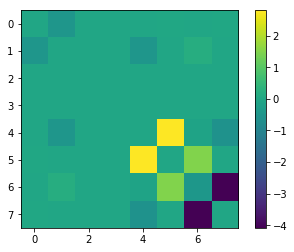

In [35]:
plt.imshow(dipole[0].real)
plt.colorbar()

In [36]:
VH_matrix=TD.get_Hartree_matrix()

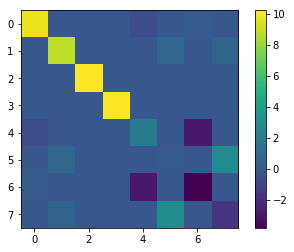

In [37]:
plt.imshow(VH_matrix[0].real)
plt.colorbar()

In [38]:
VF_matrix=TD.get_Fock_matrix()

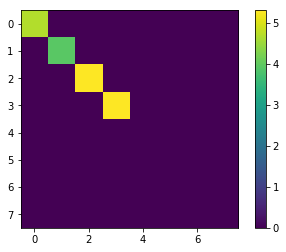

In [39]:
plt.imshow(VF_matrix[0].real)
plt.colorbar()